In [33]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/table_setting/table_setting_environments_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/table_setting/table_setting_environments_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
scenes_dataset_yaml_test = dataset_utils.ScenesDataset(DATA_DIR_TEST)
params_by_object_class = {}
num_objs_per_env = []
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    num_objs_per_env.append(env["n_objects"])
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
for env_i in range(len(scenes_dataset_yaml_test)):
    env = scenes_dataset_yaml[env_i]
    num_objs_per_env.append(env["n_objects"])
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)
    
print("%d objects max, %d objects mean" % (np.max(num_objs_per_env), np.mean(num_objs_per_env)))

fork : 
(64, 5)
means:  [0.50640191 0.50998264 3.14478268 0.02       0.14      ]
vars:  [2.31449152e-01 2.35382080e-01 1.89836943e+00 1.04083409e-17
 5.55111512e-17]
plate : 
(57, 4)
means:  [0.51154971 0.48918129 2.93688049 0.2       ]
vars:  [2.08845400e-01 2.38858533e-01 2.04016296e+00 1.66533454e-16]
spoon : 
(32, 5)
means:  [0.50095486 0.45646701 3.3195853  0.02       0.12      ]
vars:  [2.04838875e-01 1.93427278e-01 1.64974937e+00 6.93889390e-18
 8.32667268e-17]
knife : 
(56, 5)
means:  [0.50746528 0.51822917 3.34625535 0.015      0.15      ]
vars:  [2.15560900e-01 2.47008120e-01 1.90998515e+00 1.21430643e-17
 1.66533454e-16]
cup : 
(61, 4)
means:  [0.51634791 0.50018215 3.39714535 0.05      ]
vars:  [1.40643829e-01 1.51194912e-01 1.65912669e+00 4.85722573e-17]
28 objects max, 13 objects mean


15


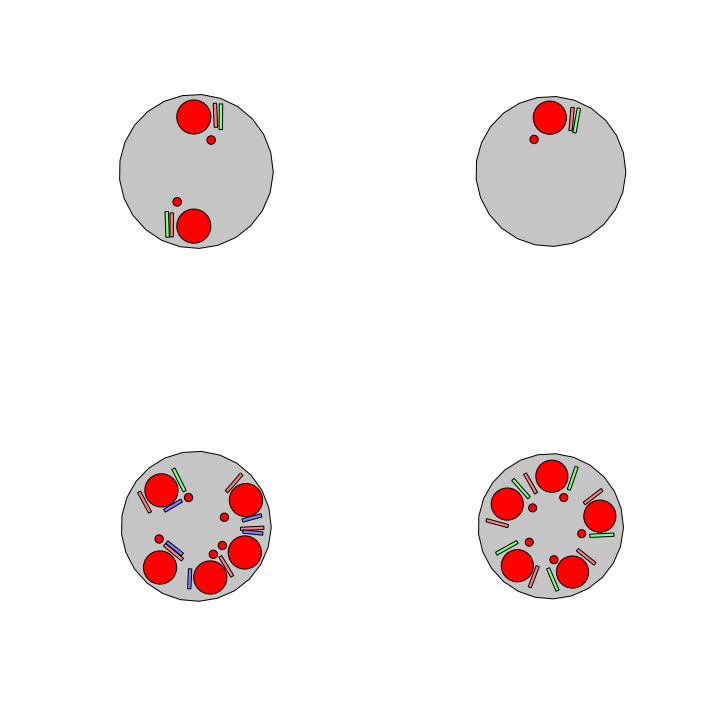

In [36]:
print len(scenes_dataset_yaml)

plt.figure().set_size_inches(10, 10)
side_width = 2
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scenes_dataset_yaml[k*side_width+l+1]
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "table_setting", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        plt.gca().set_title("")
        plt.tight_layout()

In [37]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TRAIN, max_num_objects=40,
    memorize_params=True,
    base_environment_type="table_setting")
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TEST,max_num_objects=40,
    memorize_params=True,
    base_environment_type="table_setting")
data_test = scenes_dataset_test.get_full_dataset()

print "Train batch size: ", data.batch_size
print "Test batch size: ", data_test.batch_size

print scenes_dataset.get_num_classes()
print scenes_dataset.class_id_to_name
print scenes_dataset.get_num_params_by_class()

Train batch size:  15
Test batch size:  5
5
['plate', 'spoon', 'fork', 'knife', 'cup']
[3, 3, 3, 3, 3]


In [42]:
pyro.enable_validation(True)

pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
pyro.get_param_store().save("table_setting_untrained.pyro")
#guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.001, 'betas': [0.9, 0.99], 'weight_decay': 1E-4},
      "step_size": 300,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

snapshots = {}
for i in range(0):
    start_time = time.time()
    loss = svi.step(data) / data.batch_size
    losses.append(loss)

    loss_test = svi.evaluate_loss(data_test) / data_test.batch_size
    losses_test.append(loss_test)

    end_time = time.time()
    if (i % 1 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))

    if loss_test < best_test_loss:
        pyro.get_param_store().save("best_on_test_save.pyro")
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if loss_test > 100000 or (i > 300 and cycles_since_improvement > 300):
            print("Terminating early due to rising test loss")
            break

print "Done"

Done


In [50]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
pyro.get_param_store().load("best_on_test_save.pyro")

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on all of test: ",
      svi.evaluate_loss(data_test) / data_test.batch_size)

('Loaded model evaluated on all of test: ', 51.10055847167969)


In [51]:
plt.figure().set_size_inches(12, 3)
offset = min(np.min(losses), np.min(losses_test))
plt.plot(losses - offset + 1., label="train")
plt.plot(losses_test - offset + 1., label="test")
plt.semilogy()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss (ELBO)")
plt.title("Loses: final [%f train][%f test][%f best test]" % (np.mean(losses[-20:]), np.mean(losses_test[-20:]), best_test_loss))
#print("Model evaluated on all of test: ",
#      svi.evaluate_loss(data_test) / data_test.batch_size)

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 864x216 with 0 Axes>

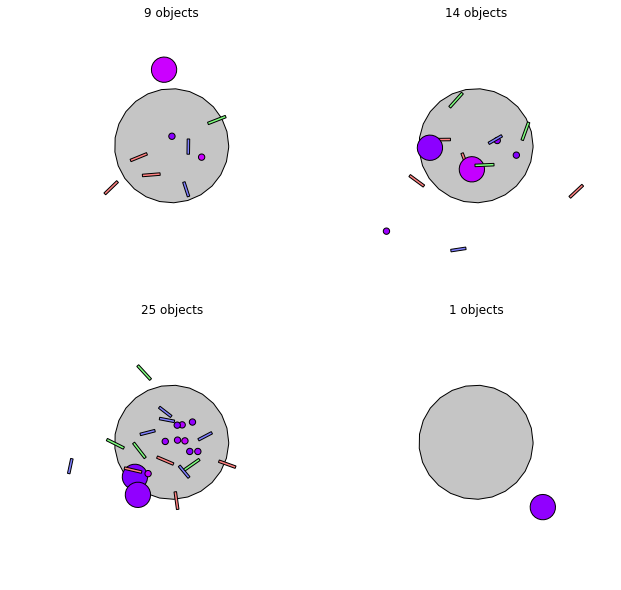

In [57]:
# Convert that data back to a YAML environment, which is easier to
# handle.
import scipy.stats
side_width = 2
generated_data, generated_encodings, generated_contexts = model.model()
scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
    generated_data)
plt.figure().set_size_inches(10, 10)
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        scene = scene_yaml[k*side_width+l+1]
        dataset_utils.DrawYamlEnvironmentPlanar(scene, "table_setting", ax=plt.gca())
        x = np.vstack(scene["obj_%04d" % k]["pose"][0:2] for k in range(scene["n_objects"]))
        plt.gca().set_title("%d objects" % scene["n_objects"])